In [83]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import numpy.random as rd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import silhouette_score
from tsp import AnnealingSolver
from leach import LeachSolver
from nemo import evaluate_nemo
import util
import seaborn as sns
from scipy.stats import lognorm
from util import centroid_label, aggp_label, coordinator_label, worker_label, ccolor, cmarker
from mst_prim import prim_mst, createRoutes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
def extract_id(index):
    return index.split('_')[0]

def extract_values(string):
    values = string.strip('()').split(', ')
    values = [value.strip("'") for value in values]
    return values

def my_sort_func(s):
    if s in ["paris", "grenoble", "lille_20", "lille", "saclay", "strasbourg"]:
        return (0, s)
    else:
        ss = s.split("-")
        #return (1, int(ss[1]))
        return(1, ss[0], int(ss[1]))

# read the contents of the file into a string
def replace_in_file(file_path, old_string, new_string):
    with open(file_path, 'r') as file:
        file_text = file.read()
    # replace all occurrences of the old string with the new string
    modified_text = file_text.replace(old_string, new_string)
    # write the modified text back to the file
    with open(file_path, 'w') as file:
        file.write(modified_text)

def diag_block_mat_boolindex(L):
    shp = L[0].shape
    mask = np.kron(np.eye(len(L)), np.ones(shp))==1
    out = np.zeros(np.asarray(shp)*len(L),dtype=int)
    out[mask] = np.concatenate(L).ravel()
    return out

def block_diag(*arrs, fillval=0):

    arrs = [np.atleast_2d(a) for a in arrs]

    shapes = np.array([a.shape for a in arrs])
    out_dtype = np.find_common_type([arr.dtype for arr in arrs], [])
    out = np.full(np.sum(shapes, axis=0), fill_value=fillval, dtype=out_dtype)

    r, c = 0, 0
    for i, (rr, cc) in enumerate(shapes):
        out[r:r + rr, c:c + cc] = arrs[i]
        r += rr
        c += cc
    return out

def calc_missing_lat(df):
    def gw(node):
        name = df.columns[node].split("_")[0]
        return list(df.columns).index(name)

    def lat(x, y):
        return df.iloc[x, y]

    for i in range(0, df.shape[0]):
        for j in range(0, df.shape[0]):
            val = df.iloc[i, j]
            if val == 0 and i != j:
                df.iloc[i, j] = lat(i, gw(i)) + lat(gw(i), gw(j)) + lat(gw(j), j)
    return df

# Calculate FitLab NCS (Skip This)

In [85]:
# Load the JSON data
loc_names = ["grenoble", "lille", "paris", "saclay", "strasbourg"]
loc_names_iter = ["grenoble", "lille_20", "paris", "saclay", "strasbourg"]
outputs = {}
max_rounds = 20
gateways = {}
calc_missing = True

# for it_r in range(0, max_rounds):
#     #create dict node-pair -> latency
#     rtt_dict = {}
#     for location in loc_names_iter:
#         #read jsons
#         with open('datasets/FIT/results_' + location + '.json') as f:
#             data = json.load(f)
#
#         for k, v in data.items():
#             if it_r >= len(v):
#                 break
#             new_k = extract_values(k)
#             if new_k[0] not in loc_names:
#                 new_k[0] = location + "_" + new_k[0]
#             if new_k[1] not in loc_names:
#                 new_k[1] = location + "_" + new_k[1]
#             new_k = (new_k[0], new_k[1])
#             if v[it_r] != "NA":
#                 rtt_dict[new_k] = float(v[it_r])
#     #parse the unique node ids
#     nodes = list(set(sum(rtt_dict.keys(), ())))
#     col_names = list(nodes)
#     col_names.sort(key=my_sort_func)
#
#     #create pandas df and store results there
#     df = pd.DataFrame(0, index=pd.Index(col_names), columns=pd.Index(col_names))
#     for col, val in rtt_dict.items():
#         c1 = col[0]
#         c2 = col[1]
#         df.loc[c1, c2] = val
#         df.loc[c2, c1] = val
#     if calc_missing:
#         df = calc_missing_lat(df)
#         df.to_csv("datasets/FIT/all/all_calc_" + str(it_r) + ".csv", header=True, index=False)
#     else:
#         df.to_csv("datasets/FIT/all/all_" + str(it_r) + ".csv", header=True, index=False)
#     print("Round Finished: ", it_r, "Shape: ", df.shape)

# Continue Here

In [86]:
df = pd.read_csv("datasets/FIT/all/all_calc_0.csv")
fit_cols = df.columns
df

,grenoble,lille,paris,saclay,strasbourg,grenoble_m3-2,grenoble_m3-11,grenoble_m3-12,grenoble_m3-13,grenoble_m3-14,...,strasbourg_m3-45,strasbourg_m3-46,strasbourg_m3-47,strasbourg_m3-49,strasbourg_m3-51,strasbourg_m3-54,strasbourg_m3-55,strasbourg_m3-58,strasbourg_m3-59,strasbourg_m3-63
0,0.000,15.000,11.800,12.100,12.600,4.890,7.930,4.390,9.730,2.760,...,13.443,13.354,13.307,13.263,13.479,13.206,13.320,13.284,13.327,13.357
1,15.000,0.000,6.690,7.100,17.700,19.890,22.930,19.390,24.730,17.760,...,18.543,18.454,18.407,18.363,18.579,18.306,18.420,18.384,18.427,18.457
2,11.800,6.690,0.000,1.820,15.500,16.690,19.730,16.190,21.530,14.560,...,16.343,16.254,16.207,16.163,16.379,16.106,16.220,16.184,16.227,16.257
3,12.100,7.100,1.820,0.000,14.600,16.990,20.030,16.490,21.830,14.860,...,15.443,15.354,15.307,15.263,15.479,15.206,15.320,15.284,15.327,15.357
4,12.600,17.700,15.500,14.600,0.000,17.490,20.530,16.990,22.330,15.360,...,0.843,0.754,0.707,0.663,0.879,0.606,0.720,0.684,0.727,0.757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,13.206,18.306,16.106,15.206,0.606,18.096,21.136,17.596,22.936,15.966,...,13.814,9.200,9.839,9.199,23.831,0.000,10.731,13.797,8.562,8.881
429,13.320,18.420,16.220,15.320,0.720,18.210,21.250,17.710,23.050,16.080,...,12.827,24.452,23.891,14.265,26.981,10.731,0.000,9.807,11.173,8.239
430,13.284,18.384,16.184,15.284,0.684,18.174,21.214,17.674,23.014,16.044,...,33.078,8.880,36.338,7.926,35.365,13.797,9.807,0.000,28.470,9.246
431,13.327,18.427,16.227,15.327,0.727,18.217,21.257,17.717,23.057,16.087,...,48.203,28.510,32.984,24.600,9.901,8.562,11.173,28.470,0.000,9.201


In [87]:
def extract_id(index):
    return index.split('_')[0]

df = pd.read_csv("datasets/FIT/coords/FIT0_calc_coords.csv", header = None, names=["x", "y"])
df.index = fit_cols
df['label'] = df.index.to_series().apply(extract_id)
df

,x,y,label
grenoble,4.56190,6.84360,grenoble
lille,-4.17850,-6.91490,lille
paris,-1.26250,-2.25620,paris
saclay,-0.14588,-2.82470,saclay
strasbourg,6.22700,-0.84394,strasbourg
...,...,...,...
strasbourg_m3-54,14.10200,-4.01350,strasbourg
strasbourg_m3-55,13.88500,-5.90200,strasbourg
strasbourg_m3-58,12.97500,-5.61380,strasbourg
strasbourg_m3-59,-8.41010,8.46420,strasbourg


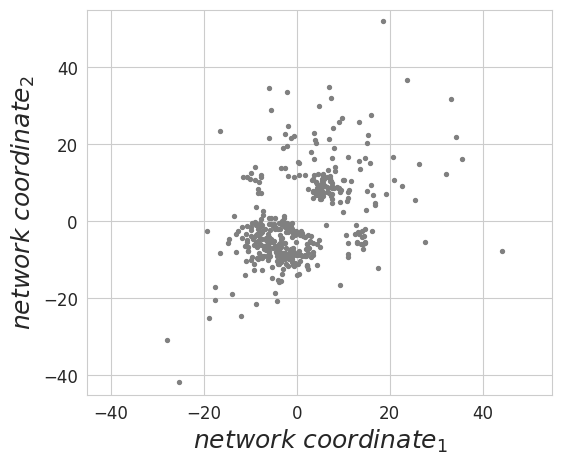

In [88]:
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

scat2 = df.plot.scatter(ax=ax1, x="x", y="y", c="grey", s=8)

#plot coordinators
#ax1.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

#ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax1.set_xlabel('$network$ $coordinate_1$', fontsize=18)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=18)

plt.xlim(-45, 55)
plt.ylim(-45, 55)

plt.savefig("plots/FIT/fit_ncs_plain.svg", bbox_inches = "tight")
plt.show()

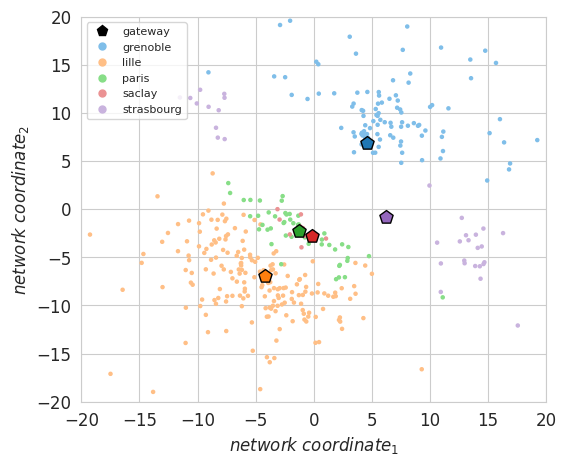

In [89]:
from matplotlib.lines import Line2D
from util import lighten_color

ms = 5
color_list = sns.color_palette(n_colors=5)
colors = np.asarray(color_list.as_hex())
light_colors = [lighten_color(x) for x in colors]
tcolors = {"grenoble": light_colors[0], "lille": light_colors[1], "paris": light_colors[2], "saclay": light_colors[3], "strasbourg": light_colors[4]}

gateway_label = Line2D([], [], color="black", marker="p", linestyle='None', label='gateway', markersize=8)
legends = [gateway_label]

for k, c in tcolors.items():
    l = Line2D([], [], color=c, marker="o", linestyle='None', label=k, markersize=ms)
    legends.append(l)

plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
scat2 = df.plot.scatter(ax=ax1, x="x", y="y", c=df["label"].map(tcolors), size=5)

for i in range(0, 5):
    ax1.scatter(df.iloc[i, 0], df.iloc[i, 1], s=100, marker="p", edgecolor="black",  color=colors[i], zorder=100)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')

ax1.legend(handles=legends, loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

plt.xlim(-20, 20)
plt.ylim(-20, 20)
#ax1.set_title('NES Topology in a Cost Space')

plt.savefig("plots/FIT/fit_ncs.svg")

plt.show()

# NEMO

In [90]:
df_fit = pd.read_csv("datasets/FIT/coords/FIT0_calc_coords.csv", header = None, names=["x", "y"])
df_fit.index = fit_cols
df_fit['label'] = df_fit.index.to_series().apply(extract_id)

tcolors = {"coordinator": "red", "worker": "grey"}
eval_matrix = {}
X_dim = [-50, 50]
Y_dim = [-50, 50]
coords = df_fit[["x", "y"]].to_numpy()
df_fit

,x,y,label
grenoble,4.56190,6.84360,grenoble
lille,-4.17850,-6.91490,lille
paris,-1.26250,-2.25620,paris
saclay,-0.14588,-2.82470,saclay
strasbourg,6.22700,-0.84394,strasbourg
...,...,...,...
strasbourg_m3-54,14.10200,-4.01350,strasbourg
strasbourg_m3-55,13.88500,-5.90200,strasbourg
strasbourg_m3-58,12.97500,-5.61380,strasbourg
strasbourg_m3-59,-8.41010,8.46420,strasbourg


5
10
15
20
[0.3199361210904246, 0.3490615116438707, 0.35330965492327715, 0.38633560261954975, 0.3661827034185494, 0.38980198845084546, 0.4063508390936998, 0.4110856878109328, 0.4089427033250701, 0.417686779850509, 0.4240465141854325, 0.377866219196271, 0.38001618220399663, 0.38152225164440073, 0.376782656790452, 0.3819850525555285]
Optimal k is  15


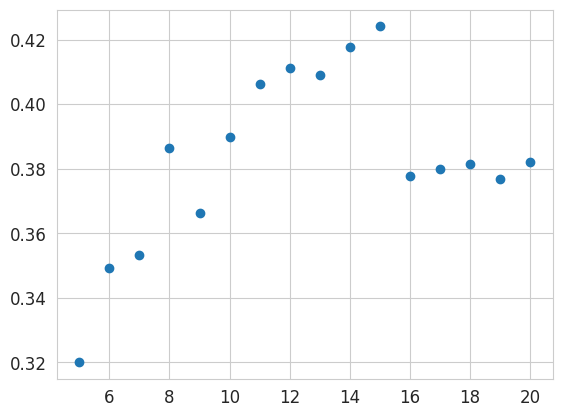

In [91]:
sil = []
kmin = 5  #max(2, centers - 5)
kmax = 20  #centers + 5
kseed = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(kmin, kmax + 1):
    if k % 5 == 0:
        print(k)
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=kseed).fit(coords)
    labels = kmeans.labels_
    sil.append(silhouette_score(coords, labels, metric='euclidean'))

print(sil)

opt_k = np.argmax(sil)
opt_k = kmin + opt_k
print("Optimal k is ", opt_k)

cluster_alg = KMeans(n_clusters=opt_k, n_init='auto').fit(coords)
labels = cluster_alg.labels_
centroids = cluster_alg.cluster_centers_
plt.scatter(x=list(range(kmin, kmax + 1)), y=sil)
df = pd.DataFrame(coords, columns=["x", "y"])
df["cluster"] = labels

In [92]:
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

color_list = sns.color_palette(n_colors=no_clusters)
colors = np.asarray(color_list.as_hex())
light_colors = [lighten_color(x) for x in colors]
color_list

Estimated no. of clusters: 15
Estimated no. of noise points: 0


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

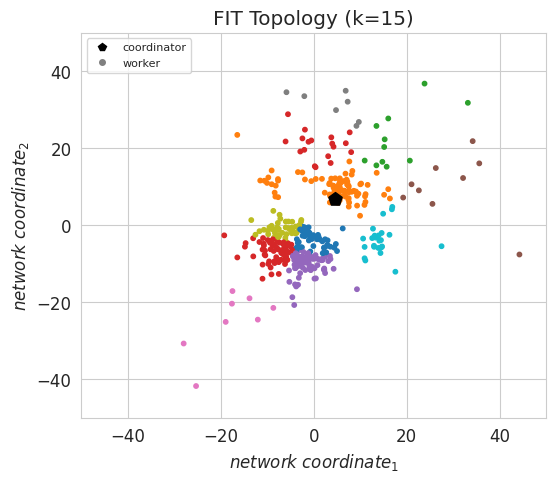

In [93]:
# add black color for outliers (if any)
super_figure = plt.figure(figsize=(6, 5))
super_plot = super_figure.add_subplot(111)
super_plot.scatter(coords[:, 0], coords[:, 1], s=10, color=colors[labels])
#super_plot.scatter(centroids[:, 0], centroids[:, 1], s=100, marker="o", color=colors)
super_plot.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

us_west_label = Line2D([], [], color=colors[0], marker="o", linestyle='None', label='US West')
europe_label = Line2D([], [], color=colors[2], marker="o", linestyle='None', label='Europe')
us_east_label = Line2D([], [], color=colors[1], marker="o", linestyle='None', label='US East')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/FIT/fit_" + str(no_clusters) + ".svg", bbox_inches = "tight")
plt.title('FIT Topology (k=' + str(no_clusters) + ")")
plt.show()

## Capacity Config

Std:  50.76010619285582


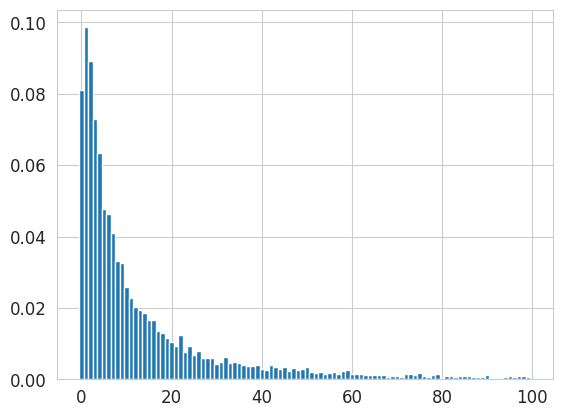

In [94]:
mode = 1
stddev = 50
sigma, scale = util.lognorm_params(mode, stddev)
sample = lognorm.rvs(sigma, 0, scale, size=10000).astype(int)

print("Std: ", np.std(sample))

H, bins = np.histogram(sample, bins=100, range=[0, 100], density=True)
plt.bar(bins[:-1],H,width=1)
plt.show()

In [95]:
capacity_columns = []
np.random.seed(4)
avg = 50
c_coords = coords[0]
device_number = len(df_fit)
max_resources = device_number*avg - 100
type_list = ["worker" for x in range(device_number - 1)]
type_list.insert(0, "coordinator")

df['latency'] = list(zip(df.x, df.y))
df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - c_coords))
df["type"] = pd.Series(type_list, dtype="category")
df.loc[0, "cluster"] = -1

sums = []
for i in range(len(H), 0, -1):
    if (i % 10 == 0) or (i == 5) or (i == 1):
        #probabilites
        p = np.array(H[i-1:len(H)])
        p /= p.sum()  # normalize
        pop = np.arange(i-1, len(H))

        capacity_list = np.random.choice(pop, len(df)-1, p=p, replace=True)
        capacity_list =np.insert(capacity_list, 0, 0)

        col = "capacity_"+str(i)
        df[col] = pd.Series(capacity_list, dtype="int")
        df["capacity_"+str(i)] = df[col] / df[col].sum() * max_resources

        df[col] = np.ceil(df[col]).astype("int")
        df.at[0, col] = 100
        sums.append((df[col].sum()))
        capacity_columns.append(col)

print(sums)
prim_df = df.copy()

[21700, 21895, 21870, 21865, 21874, 21872, 21878, 21870, 21863, 21869, 21805, 21861]


In [96]:
prim_df

,x,y,cluster,latency,type,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1
0,4.56190,6.84360,-1,0.000000,coordinator,100,100,100,100,100,100,100,100,100,100,100,100
1,-4.17850,-6.91490,13,16.300028,worker,50,53,47,48,41,48,58,34,52,41,13,139
2,-1.26250,-2.25620,0,10.804166,worker,50,52,51,55,42,60,79,97,87,21,13,23
3,-0.14588,-2.82470,0,10.753568,worker,50,48,55,53,58,57,35,36,41,35,60,158
4,6.22700,-0.84394,0,7.865801,worker,50,52,45,47,45,39,74,51,39,21,18,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,14.10200,-4.01350,9,14.453032,worker,50,50,50,55,57,59,63,55,43,20,50,19
429,13.88500,-5.90200,9,15.791470,worker,50,51,51,48,42,38,33,79,26,42,13,16
430,12.97500,-5.61380,9,15.032201,worker,50,48,50,45,63,70,40,58,68,109,113,8
431,-8.41010,8.46420,11,13.072839,worker,50,52,51,53,59,71,33,33,55,35,23,68


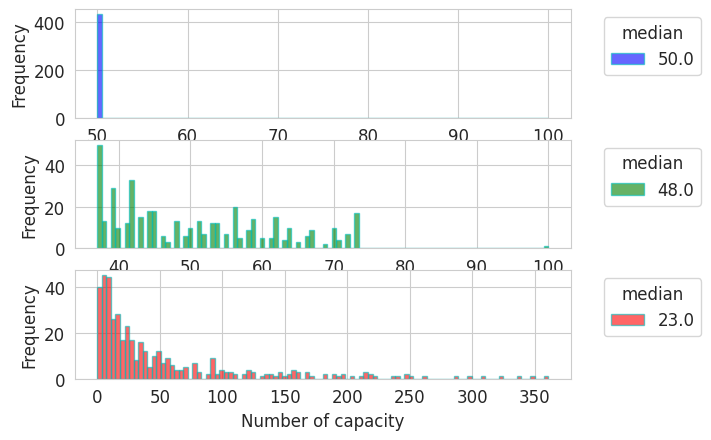

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

i=100
df["capacity_"+str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c', label=df["capacity_"+str(i)].median())

i=50
df["capacity_"+str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c', label=df["capacity_"+str(i)].median())

i=1
df["capacity_"+str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c', label=df["capacity_"+str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')

ax3.set_xlabel("Number of capacity")

plt.show()

Medians from  50  to  20


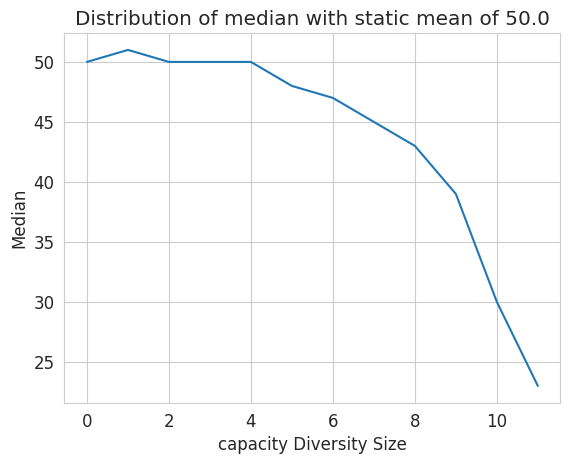

In [98]:
medians = []
mean = np.floor(prim_df["capacity_"+str(1)].mean())

for col in capacity_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = str(int(medians[0] - medians[0] % 5))
last_med_label = str(int(medians[-1] - medians[-1] % 5))
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("capacity Diversity Size")
plt.show()

### Experiment 1: Send all data directly to coordinator

In [99]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    latency_hist[i] = np.linalg.norm(coords[i] - c_coords)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
eval_matrix["dt"] = df_stats.copy()

### Experiment 2: LEACH Protocol

In [100]:
seed = 20
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = int(device_number*0.1)

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  43
[371, 352, 403, 393, 78, 134, 346, 326, 52, 168, 294, 87, 14, 211, 209, 39, 53, 65, 164, 243, 298, 231, 107, 103, 163, 321, 349, 172, 169, 219, 48, 322, 266, 413, 431, 252, 208, 42, 106, 125, 18, 104, 49]


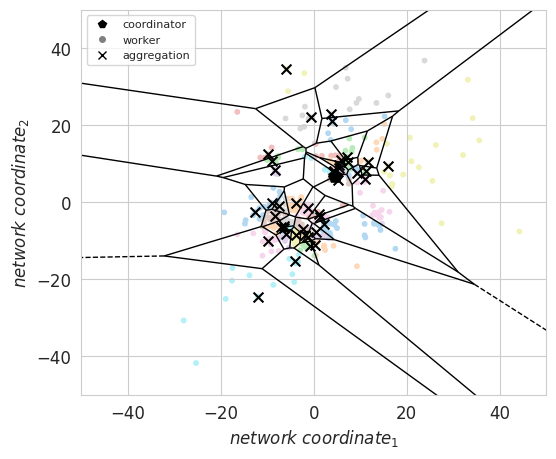

In [101]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, aggp_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/FIT/leach.svg")
plt.show()

count    433.000000
mean      17.187975
std       15.411815
min        0.000000
25%       11.698641
50%       17.053333
75%       19.474389
max      254.226860
Name: latency_distribution, dtype: float64


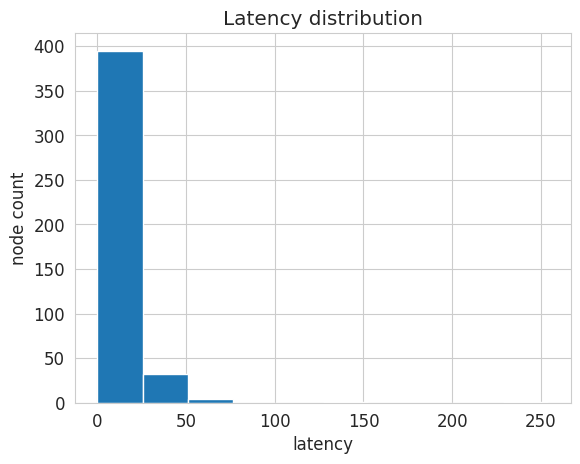

In [102]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())
eval_matrix["leach"] = df_stats.copy()

### Experiment 3a: NEMO Aggregation with Density-based Grouping

In [103]:
prim_df

,x,y,cluster,latency,type,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1
0,4.56190,6.84360,-1,0.000000,coordinator,100,100,100,100,100,100,100,100,100,100,100,100
1,-4.17850,-6.91490,13,16.300028,worker,50,53,47,48,41,48,58,34,52,41,13,139
2,-1.26250,-2.25620,0,10.804166,worker,50,52,51,55,42,60,79,97,87,21,13,23
3,-0.14588,-2.82470,0,10.753568,worker,50,48,55,53,58,57,35,36,41,35,60,158
4,6.22700,-0.84394,0,7.865801,worker,50,52,45,47,45,39,74,51,39,21,18,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,14.10200,-4.01350,9,14.453032,worker,50,50,50,55,57,59,63,55,43,20,50,19
429,13.88500,-5.90200,9,15.791470,worker,50,51,51,48,42,38,33,79,26,42,13,16
430,12.97500,-5.61380,9,15.032201,worker,50,48,50,45,63,70,40,58,68,109,113,8
431,-8.41010,8.46420,11,13.072839,worker,50,52,51,53,59,71,33,33,55,35,23,68


In [104]:
# assign nodes to previous clustering alg
iterations = 100
W = 80
L = 100

capacity_col = "capacity_100"
med_label = first_med_label
eval_name = "nemo_dc"
eval_matrix[eval_name], new_paths_flat, agg_dict_flat, df_dict_flat = evaluate_nemo(prim_df, coords, W, L, False, capacity_columns, iterations)

Starting nemo for  base
Starting nemo for  capacity_100
Starting nemo for  capacity_90
Starting nemo for  capacity_80
Starting nemo for  capacity_70
Starting nemo for  capacity_60
Starting nemo for  capacity_50
Starting nemo for  capacity_40
Starting nemo for  capacity_30
Starting nemo for  capacity_20
Starting nemo for  capacity_10
Starting nemo for  capacity_5
Starting nemo for  capacity_1


In [105]:
reassigned_clussters = util.get_diff(agg_dict_flat["base"], agg_dict_flat[capacity_col])
print(reassigned_clussters)

[0, 1, 13, 14]


In [106]:
#Test to see if there are any overloaded nodes, result should be empty
df_overloaded = df_dict_flat[capacity_col].groupby(['parent']).size()
df_capacity = df_dict_flat[capacity_col][capacity_col][df_overloaded.index]
result = pd.concat([df_capacity, df_overloaded], axis=1).reindex(df_overloaded.index)
result.columns = ["capacity", "count"]
result["load"] = result["capacity"] - result["count"]
result[result["load"] < 0]

,capacity,count,load
parent,,,


In [107]:
centroids

array([[  -0.26560252,   -3.60952931],
       [   6.70563512,    8.99276707],
       [-226.69      ,   75.734     ],
       [   1.07847167,   20.75888889],
       [  63.266     ,  118.63      ],
       [  28.96733333,    9.98092222],
       [ -17.7342875 ,  -25.006625  ],
       [   6.0670125 ,   33.717375  ],
       [  -6.74567556,   -0.97262452],
       [  14.3988    ,   -3.9563084 ],
       [  -8.6439    ,   61.669     ],
       [  -7.80789824,   11.92810588],
       [  17.48563636,   22.31918182],
       [  -8.32361127,   -6.83420423],
       [  -1.40405962,  -10.26669359]])

In [108]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

In [109]:
cluster_coords_with_crd

array([[   4.5619    ,    6.8436    ],
       [  -0.26560252,   -3.60952931],
       [   6.70563512,    8.99276707],
       [-226.69      ,   75.734     ],
       [   1.07847167,   20.75888889],
       [  63.266     ,  118.63      ],
       [  28.96733333,    9.98092222],
       [ -17.7342875 ,  -25.006625  ],
       [   6.0670125 ,   33.717375  ],
       [  -6.74567556,   -0.97262452],
       [  14.3988    ,   -3.9563084 ],
       [  -8.6439    ,   61.669     ],
       [  -7.80789824,   11.92810588],
       [  17.48563636,   22.31918182],
       [  -8.32361127,   -6.83420423],
       [  -1.40405962,  -10.26669359]])

In [110]:
mst

[-1, 0, 0, 11, 12, 11, 13, 14, 4, 1, 0, 8, 9, 8, 9, 1]

In [111]:
len(cluster_coords_with_crd)

16

In [112]:
max(mst)

14

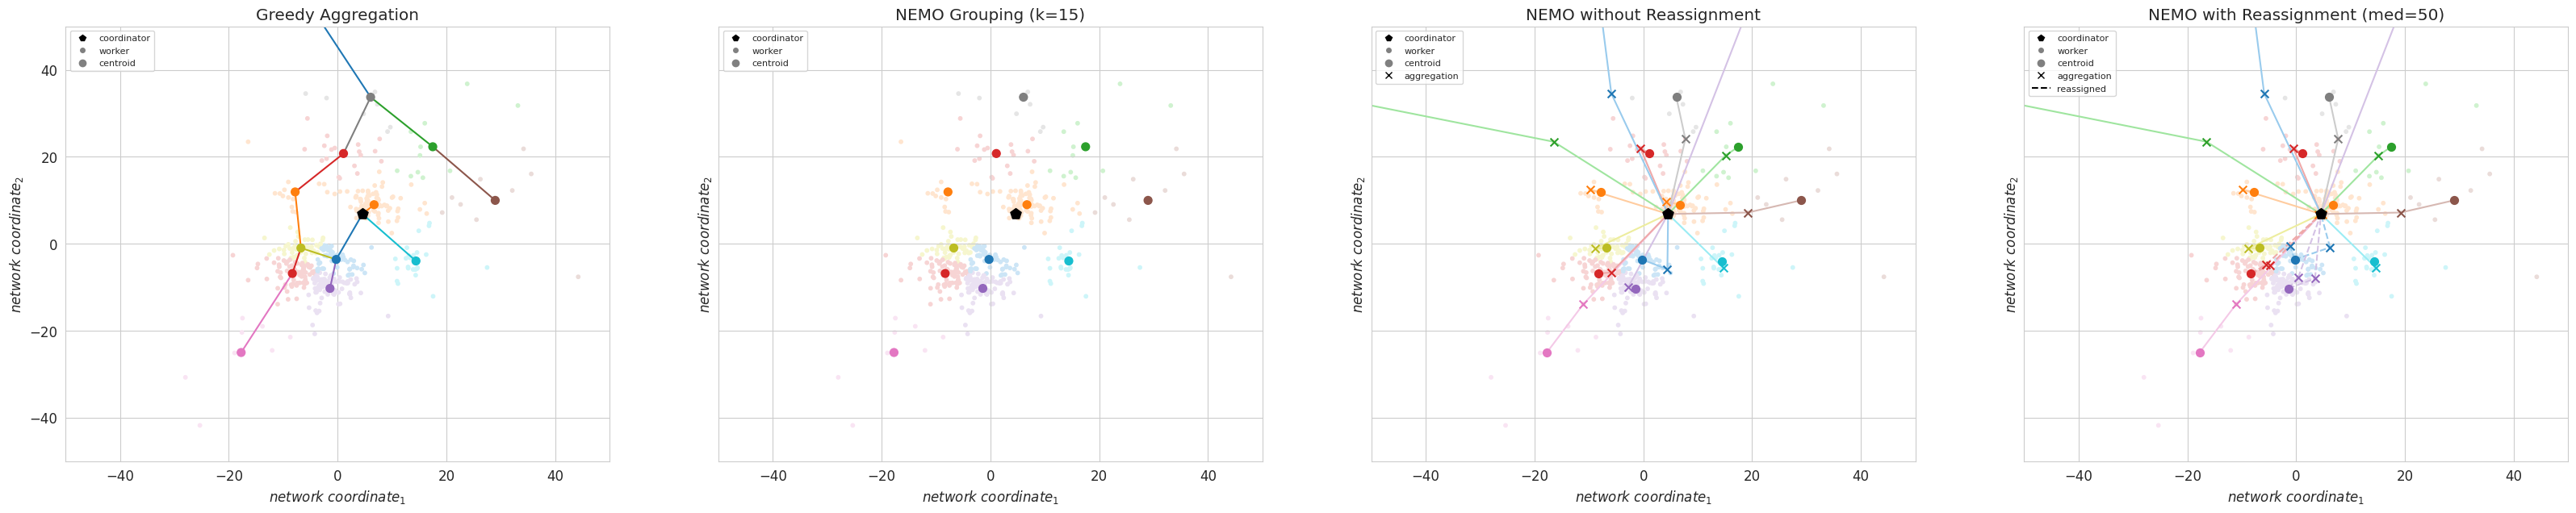

In [113]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.2

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i-1])

ax1.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
ax1.set_title('Greedy Aggregation')

#plot grouping
ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)

ax2.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax2.set_title('NEMO Grouping (k=' + str(opt_k) + ")")
ax2.set_xlabel('$network$ $coordinate_1$')
ax2.set_ylabel('$network$ $coordinate_2$')

#plot our solutions
util.plot(ax3, new_paths_flat["base"], agg_dict_flat["base"], c_coords, cluster_coords, coords, colors, labels, lval=lval)
util.plot(ax4, new_paths_flat[capacity_col], agg_dict_flat[capacity_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)

plt.xlim(X_dim)
plt.ylim(Y_dim)
ax3.set_title("NEMO without Reassignment")
ax4.set_title("NEMO with Reassignment (med=" + med_label + ")")

plt.savefig("plots/FIT/nemo_phases_fit.svg",  bbox_inches="tight")

# Save just the portion _inside_ the second axis's boundaries
names = ["greedy.svg", "nemo_grouping.svg", "nemo_plcmt.svg", "nemo_reassignment.svg"]
axes = [ax1, ax2, ax3, ax4]
#for i in range(0, 4):
#    extent = util.full_extent(axes[i]).transformed(fig.dpi_scale_trans.inverted())
#    fig.savefig("plots/FIT/" + names[i], bbox_inches="tight")

plt.show()

### Experiment 3b: NEMO Aggregation with Random Grouping


In [114]:
np.random.seed(10)
random_labels = np.random.randint(0, no_clusters, df.shape[0])
random_labels[0] = -1
iterations = 100
W = 80
L = 100
df = prim_df.copy()
df["cluster"] = random_labels

In [115]:
eval_name = "nemo_rc"
eval_matrix[eval_name], new_paths_rdm, agg_dict_rdm, df_dict_rdm = evaluate_nemo(df, coords, W, L, False, capacity_columns, iterations)

Starting nemo for  base
Starting nemo for  capacity_100
Starting nemo for  capacity_90
Starting nemo for  capacity_80
Starting nemo for  capacity_70
Starting nemo for  capacity_60
Starting nemo for  capacity_50
Starting nemo for  capacity_40
Starting nemo for  capacity_30
Starting nemo for  capacity_20
Starting nemo for  capacity_10
Starting nemo for  capacity_5
Starting nemo for  capacity_1


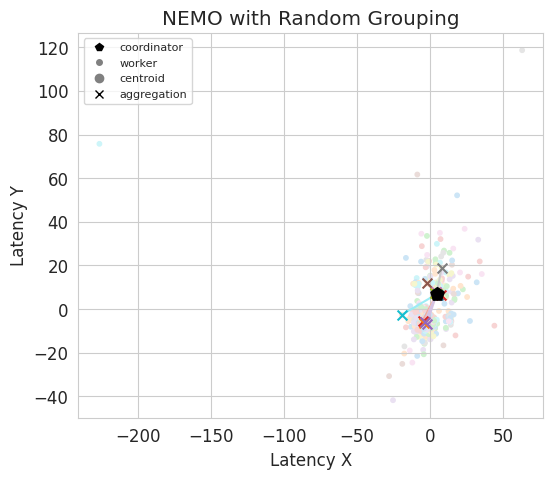

In [116]:
fig = plt.figure(figsize=(6, 5))
lval = 0.2

f1 = fig.add_subplot(111)
random_labels[0] = 0
util.plot(f1, new_paths_rdm["base"], agg_dict_rdm["base"], c_coords, None, coords, colors, random_labels, lval=lval, print_centroids=False)

plt.xlabel('Latency X')
plt.ylabel('Latency Y')
plt.title('NEMO with Random Grouping')

plt.show()

Distribution of workload:  2.7714 %


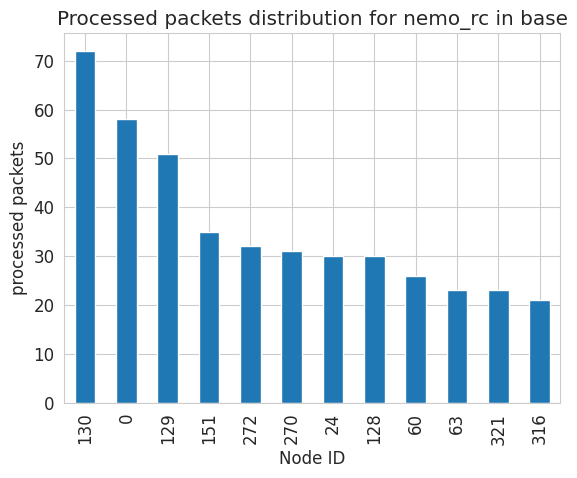

In [117]:
eval_col = list(eval_matrix[eval_name])[0]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [118]:
mst = prim_mst(coords)

In [119]:
print(mst)

[-1, 206, 400, 345, 384, 112, 90, 112, 34, 68, 130, 53, 7, 9, 21, 33, 97, 66, 21, 6, 12, 88, 61, 95, 45, 60, 72, 36, 14, 78, 24, 38, 14, 81, 91, 31, 89, 93, 96, 128, 55, 49, 65, 51, 55, 114, 93, 107, 85, 99, 63, 110, 32, 28, 67, 75, 102, 59, 59, 42, 115, 104, 26, 105, 105, 48, 108, 57, 123, 64, 134, 85, 70, 50, 132, 84, 71, 80, 70, 37, 88, 16, 78, 69, 73, 50, 11, 77, 20, 46, 97, 49, 41, 69, 15, 74, 27, 32, 57, 103, 81, 35, 79, 118, 82, 8, 54, 92, 62, 22, 119, 25, 95, 413, 23, 110, 106, 58, 109, 17, 122, 106, 98, 103, 101, 130, 0, 125, 143, 125, 139, 30, 82, 0, 127, 141, 128, 126, 136, 133, 10, 129, 39, 0, 288, 165, 271, 201, 174, 198, 208, 185, 298, 178, 291, 170, 173, 148, 194, 302, 259, 285, 177, 166, 249, 253, 156, 193, 311, 211, 161, 147, 322, 322, 334, 284, 316, 328, 157, 289, 269, 196, 242, 320, 313, 152, 195, 266, 236, 214, 250, 299, 317, 227, 313, 220, 265, 217, 189, 218, 205, 167, 184, 183, 208, 224, 180, 306, 235, 254, 200, 338, 312, 229, 213, 210, 205, 171, 150, 149, 146, 33

In [120]:
routes = createRoutes(mst)
print(routes[3])

[345, 389, 382, 392, 2, 400, 390, 349, 343, 348, 374, 361, 397, 363, 352, 362, 310, 287, 360, 296, 314, 256, 282, 283, 190, 250, 293, 301, 326, 275, 290, 364, 341, 286, 406, 414, 431, 423, 425, 421, 111, 25, 60, 115, 110, 119, 17, 66, 108, 62, 26, 72, 70, 134, 127, 125, 130, 139, 133, 0]


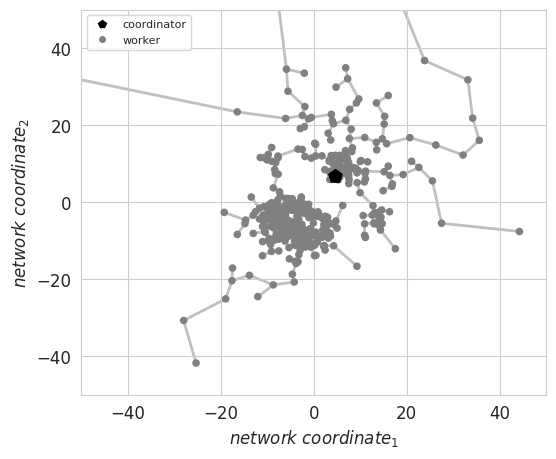

In [121]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=df["type"].map(tcolors), ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/FIT/mst_fit.svg", bbox_inches = "tight")
plt.show()

In [122]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
eval_matrix["mst"] = df_stats.copy()

### Experiment 5: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [123]:
# the adjacency matrix for the plane
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords)

i:0, t(i):10.00, valueNow:4858.0, valueBest:4642.0
i:10, t(i):3.49, valueNow:4284.0, valueBest:4284.0
i:20, t(i):1.22, valueNow:3443.0, valueBest:3443.0
i:30, t(i):0.42, valueNow:3171.0, valueBest:3170.0
i:40, t(i):0.15, valueNow:3021.0, valueBest:3021.0
i:50, t(i):0.05, valueNow:2886.0, valueBest:2886.0
i:60, t(i):0.02, valueNow:2802.0, valueBest:2802.0


In [124]:
print(route)

[398   0  78 131 355 170 247 155 144 288 206 378 262 154 223 146 175 345
 383 354 344 292 338 306 227 193 289 373 365 136  82  29 134 342 291 336
 189 149 237 161 240 298 320 202 280 183 203 267 276 368 408 226 159 174
 334 249 179 327 164 277 234 319 255 333 181 318 339 153 244 217 208 185
 242 285 192 260 371 246   4 384 370 337 299 191 409 418 429 273 340 419
 424 415 142  39  74  19 377 372 393 346 278 209 308 307 330 178 245 400
 343  45  53 430 407 428 417 432 422 412 369 379 328 325 281 300 283 349
 374 356 421  60 115 119 110  91  34  12  21  87  14 353 397 367 375 350
 141  72 129 341 413 425 427 113 135 381 366 126 143  24 114  95  41  69
  46  31  38  96  33  89  99 109 118  68  50  75  55  40   7 395   3 394
 420 426 411  86  64  84 102  35  73  76 103 128 130  98  58  71  56  36
 100  52  97   6  32 416  16  83  22  62 108 423 286 140 127  10 139  70
 104  47  77  80  90  81  93  63  48  65  44  79  37  27 124 101   8 404
 402  15  94  92  61  51  43  42  67  57  85 105  4

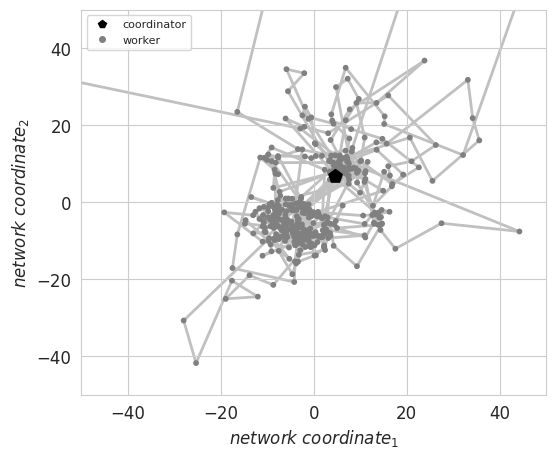

In [125]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=df["type"].map(tcolors), s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/FIT/chain_50n.svg", bbox_inches = "tight")
plt.show()

In [126]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  1  in route.


In [127]:
print(df_stats["received_packets"])

0      2.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
428    1.0
429    1.0
430    1.0
431    1.0
432    1.0
Name: received_packets, Length: 433, dtype: float64


count     433.000000
mean     1339.237714
std       961.945321
min         0.000000
25%       412.413262
50%      1055.641174
75%      2367.132442
max      2749.493107
Name: latency_distribution, dtype: float64


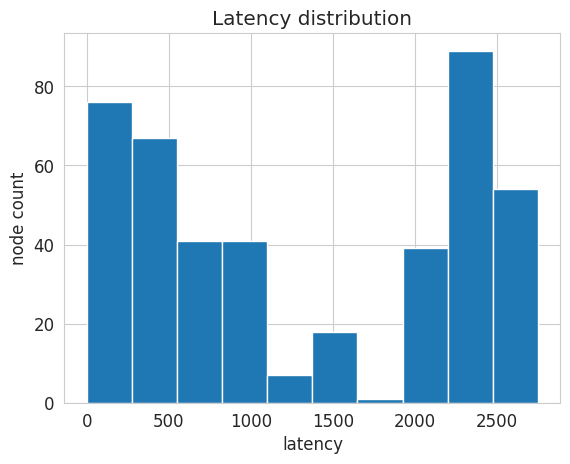

In [128]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

count     433.000000
mean     1339.237714
std       961.945321
min         0.000000
25%       412.413262
50%      1055.641174
75%      2367.132442
max      2749.493107
Name: latency_distribution, dtype: float64
count    433.000000
mean       0.997691
std        0.083301
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: received_packets, dtype: float64


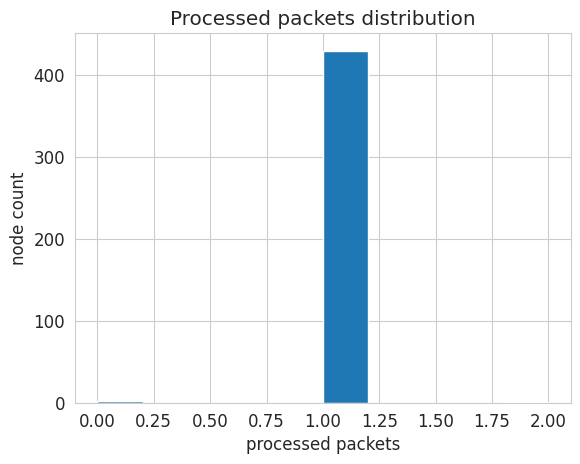

In [129]:
print(df_stats["latency_distribution"].describe())
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()

In [130]:
np.where(received_packets_hist > 1)

(array([0]),)

## Evaluation

In [131]:
eval_matrix.keys()

dict_keys(['dt', 'leach', 'nemo_dc', 'nemo_rc', 'mst', 'chain'])

In [132]:
eval_matrix["dt"]

,latency_distribution,received_packets
0,0.000000,432.0
1,16.300028,0.0
2,10.804166,0.0
3,10.753568,0.0
4,7.865801,0.0
...,...,...
428,14.453032,0.0
429,15.791470,0.0
430,15.032201,0.0
431,13.072839,0.0


In [133]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_rc', 'nemo_dc']

color_list = sns.color_palette(n_colors=7)
colors = np.asarray(color_list.as_hex())

eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6]
}

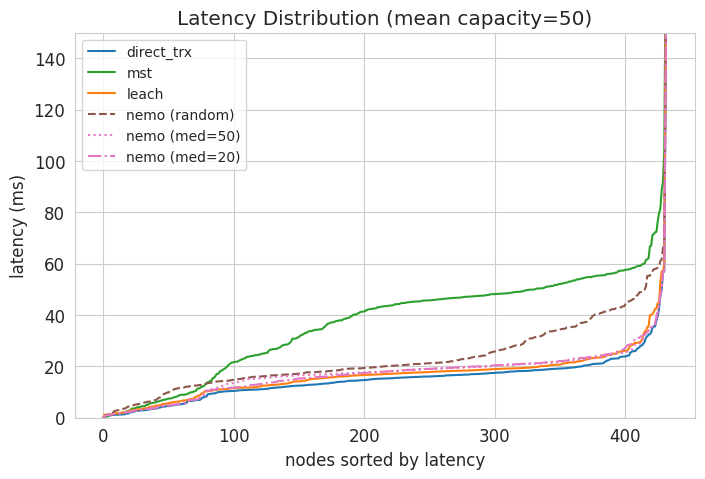

Means:  {'dt': 15.49, 'mst': 37.46, 'leach': 17.19, 'chain': 1339.24, 'nemo (random)': 23.58, 'nemo (med=50)': 17.87, 'nemo (med=20)': 17.66}
Quantiles:  {'dt': 22.87, 'mst': 56.12, 'leach': 24.48, 'chain': 2525.46, 'nemo (random)': 42.0, 'nemo (med=50)': 24.47, 'nemo (med=20)': 24.88}


In [134]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    elif l == "chain":
        continue
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for l in heterogen_appr:
    if l in ["nemo_dc", "nemo_rc"]:
        cl = l
        emat = eval_matrix[l]
        #print("Mean latency ", l, ": ", round(emat["capacity_50"]["latency_distribution"].mean(), 2))

        if l == "nemo_dc":
            l = "nemo"
        elif l == "nemo_rc":
            l = "nemo (random)"

        i = 0
        for k, df in emat.items():
            if l != "nemo" and k != "base":
                continue
            #if i % 50 == 0:
            if l=="nemo" and k == "base":
                continue
                sv = df["latency_distribution"].sort_values()
                sv.plot(ax=ax1, use_index=False, label=l + " (base)", color=eval_colors[cl+"_base"], linestyle="--")
            elif k == "base":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l] = round(sv.quantile(0.9), 2)
                mean_dict[l] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl+"_base"], linestyle="--")
            elif k == "capacity_100":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l+" (med="+ first_med_label + ")"] = round(sv.quantile(0.9), 2)
                mean_dict[l+" (med="+ first_med_label + ")"] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label=l+" (med="+ first_med_label + ")", color=eval_colors[cl], linestyle=":")
            elif k == "capacity_1":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l+" (med="+ last_med_label + ")"] = round(sv.quantile(0.9), 2)
                mean_dict[l+" (med="+ last_med_label + ")"] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label= l+" (med="+ last_med_label + ")", color=eval_colors[cl], linestyle="-.")
            i += 1

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 150])
plt.savefig("plots/FIT/eval_latency.svg")
ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

In [135]:
load_dict = {}
nn_dict = {}
for k, df in eval_matrix.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in capacity_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in capacity_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix.items():
    if k in heterogen_appr:
        capacity_list = []
        nn_list = []
        for colname in capacity_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            capacity_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = capacity_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix.items():
    if k in heterogen_appr:
        capacity_list = []
        nn_list = []
        for colname in capacity_columns:
            df = mat["base"]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            capacity_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k + "_base"] = capacity_list
        nn_dict[k + "_base"] = nn_list
load_dict.keys()
agg_arr1 = []
for fam in heterogen_appr:
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])
mr = np.mean(np.array(agg_arr1), axis=0)
load_dict["NEMO+redistribution"] = mr
print(mr)

agg_arr2 = []
for fam in heterogen_appr:
    agg_arr2.append(load_dict[fam + "_base"])
mr = np.mean(np.array(agg_arr2), axis=0)
load_dict["NEMO_base"] = mr
print(mr)

Fam:  nemo_rc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fam:  nemo_dc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3.  2.5 2.5 3.  3.  3.5 2.5 2.5 4.  3.  4.5 6. ]


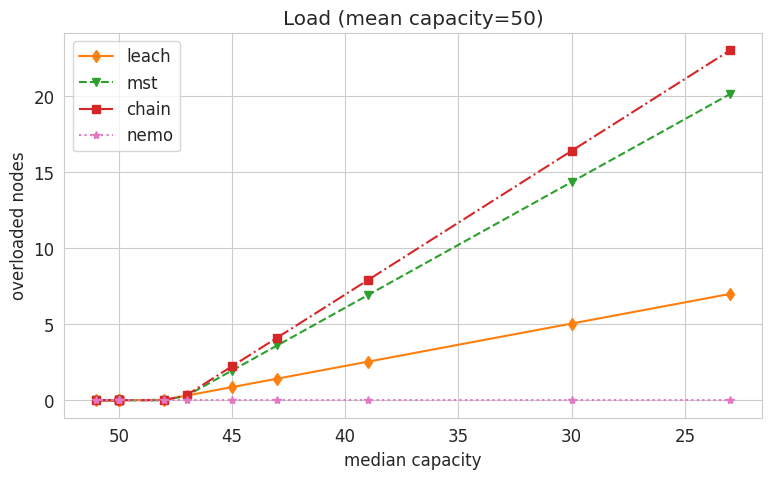

In [136]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in aggregation_fams + ["NEMO+redistribution", "NEMO_base"]:
    vals = load_dict[fam]
    evcol = fam
    m, b = np.polyfit(medians, vals, 1)
    if fam == "sbon":
        fam = "sbon+NEMO_grouping"
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "NEMO+redistribution":
        fam = "nemo"
    if fam == "NEMO_base":
        fam = "nemo (base)"
        continue
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")

#ax.set_yscale('log')
ax.legend()
plt.savefig("plots/FIT/eval_load.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()